# Assignment 2. Deep Learning Fundamentals

In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
import copy
from PIL import Image

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

## 1. Load data

In [2]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))
])

# Load CIFAR-10 dataset and split into training and validation sets
train_val_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:04<00:00, 34.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
num_workers = os.cpu_count()

train_size = int(0.8 * len(train_val_data))
val_size = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=200, num_workers=num_workers, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=200, num_workers=num_workers, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=200, num_workers=num_workers, shuffle=False, pin_memory=True)

## 2. Exploratory Data Analysis

In [4]:
# See the classes
train_val_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

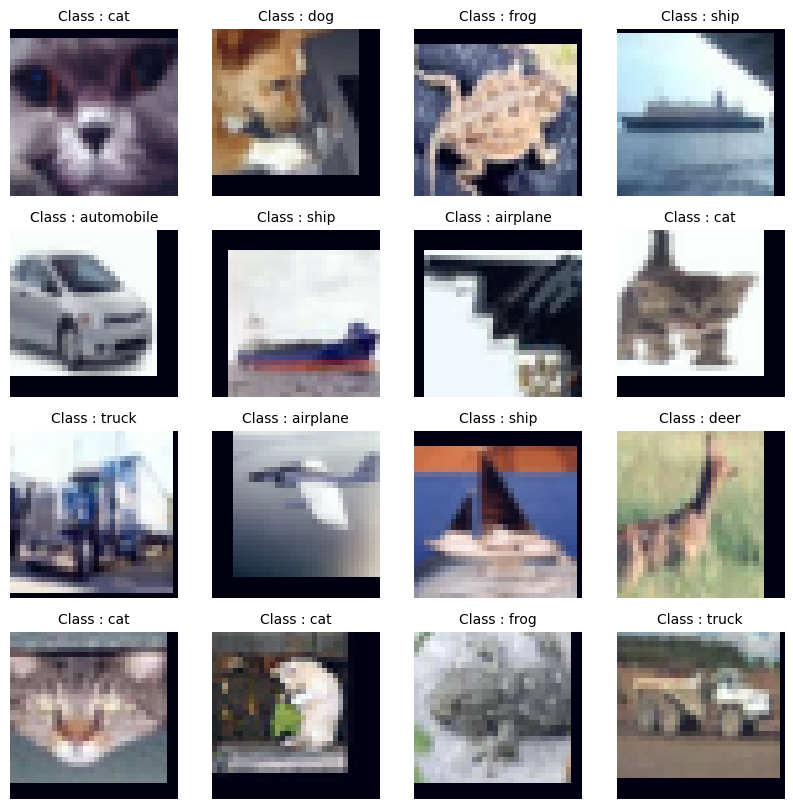

In [5]:
# Plot random images from the training validation set
rand_idx = random.sample(range(len(train_val_data)),k=16)

plt.figure(figsize=(10,10))

for i , idx in enumerate(rand_idx):

  img , label = train_val_data[idx]
  img = (img - img.min()) / (img.max() - img.min())

  img_class = train_val_data.classes[label]

  plt.subplot(4,4,i+1)
  plt.imshow(img.permute(1,2,0))
  plt.title(f"Class : {img_class}",fontsize=10)
  plt.axis(False)

# 3. Fine-tune models

In [6]:
# Define model function
def initialize_model(model_name, num_classes=10, pretrained=True):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)  # Train from scratch
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()  # Remove max
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)  # Fine-tune version
        model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        model.features[2] = nn.Identity()  # Remove max
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "mobilenet":
        model = models.mobilenet_v2(pretrained=True)  # Fine-tune version
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

In [7]:
# Define the training phase function
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    return model, train_loss, train_accuracy

In [8]:
# Define the validation phase function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [9]:
# Function to train and validate model
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model, train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)

        # Validation phase
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)

        # Check if validation accuracy improved
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping condition
        if epochs_no_improve >= 5:
            print(f"Early stopping on epoch {epoch+1} with best validation accuracy: {best_val_accuracy:.4f}")
            break

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [10]:
# Function to run fine-tuning model
def find_best_model_config(model_name, learning_rates, optimizers, train_loader, val_loader, device, num_epochs=20):
    best_val_accuracy = 0.0
    best_config = None
    results = {}

    for lr in learning_rates:
        for opt in optimizers:
            print(f"\nTraining {model_name} with {opt} optimizer and learning rate {lr}")
            model = initialize_model(model_name).to(device)
            criterion = nn.CrossEntropyLoss()

            # Choose optimizer
            if opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
            elif opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
            else:
                optimizer = optim.RMSprop(model.parameters(), lr=lr)

            # Train and validate the model
            model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_and_validate(
                model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
            )

            # Store results
            results[(model_name, lr, opt)] = (train_loss_history, val_loss_history, train_acc_history, val_acc_history)

            # Check if this configuration has the best validation accuracy so far
            max_val_acc = max(val_acc_history)
            if max_val_acc > best_val_accuracy:
                best_val_accuracy = max_val_acc
                best_config = (model_name, lr, opt)

    # Output the best configuration and its validation accuracy
    print(f"\nBest configuration: Model={best_config[0]}, Learning Rate={best_config[1]}, Optimizer={best_config[2]}")
    print(f"Best Validation Accuracy: {best_val_accuracy}")

    return best_config, best_val_accuracy, results

In [11]:
# Define models and hyperparameters
model_names = ["resnet18", "alexnet", "mobilenet"]
num_epochs = 20
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['SGD', 'Adam', 'RMSprop']

In [12]:
# Best resnet18 model
best_resnet_config, best_resnet_val_accuracy, results_restnet = find_best_model_config(
    model_name=model_names[0],
    learning_rates=learning_rates,
    optimizers=optimizers,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs
)


Training resnet18 with SGD optimizer and learning rate 0.1


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Epoch 1/20, Train Loss: 2.7103, Train Acc: 0.2041, Val Loss: 2.1897, Val Acc: 0.1757
Epoch 2/20, Train Loss: 1.7727, Train Acc: 0.3342, Val Loss: 1.9115, Val Acc: 0.3041
Epoch 3/20, Train Loss: 1.6090, Train Acc: 0.4040, Val Loss: 5.1699, Val Acc: 0.1157
Epoch 4/20, Train Loss: 1.5040, Train Acc: 0.4521, Val Loss: 3.6254, Val Acc: 0.1597
Epoch 5/20, Train Loss: 1.4074, Train Acc: 0.4905, Val Loss: 1.9190, Val Acc: 0.3489
Epoch 6/20, Train Loss: 1.3685, Train Acc: 0.5101, Val Loss: 2.2102, Val Acc: 0.3065
Epoch 7/20, Train Loss: 1.3365, Train Acc: 0.5245, Val Loss: 1.8503, Val Acc: 0.3802
Epoch 8/20, Train Loss: 1.3120, Train Acc: 0.5322, Val Loss: 2.1708, Val Acc: 0.3237
Epoch 9/20, Train Loss: 1.2836, Train Acc: 0.5445, Val Loss: 4.5708, Val Acc: 0.1537
Epoch 10/20, Train Loss: 1.2573, Train Acc: 0.5554, Val Loss: 2.6136, Val Acc: 0.2349
Epoch 11/20, Train Loss: 1.2742, Train Acc: 0.5483, Val Loss: 2.4546, Val Acc: 0.2857
Epoch 12/20, Train Loss: 1.2507, Train Acc: 0.5576, Val Loss: 2

In [13]:
# Best alexnet model
best_alexnet_config, best_alexnet_val_accuracy, results_alexnet = find_best_model_config(
    model_name=model_names[1],
    learning_rates=learning_rates,
    optimizers=optimizers,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs
)


Training alexnet with SGD optimizer and learning rate 0.1


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 142MB/s]


Epoch 1/20, Train Loss: nan, Train Acc: 0.0994, Val Loss: nan, Val Acc: 0.1039
Epoch 2/20, Train Loss: nan, Train Acc: 0.0990, Val Loss: nan, Val Acc: 0.1039
Epoch 3/20, Train Loss: nan, Train Acc: 0.0990, Val Loss: nan, Val Acc: 0.1039
Epoch 4/20, Train Loss: nan, Train Acc: 0.0990, Val Loss: nan, Val Acc: 0.1039
Epoch 5/20, Train Loss: nan, Train Acc: 0.0990, Val Loss: nan, Val Acc: 0.1039
Epoch 6/20, Train Loss: nan, Train Acc: 0.0990, Val Loss: nan, Val Acc: 0.1039
Early stopping on epoch 6 with best validation accuracy: 0.1039

Training alexnet with Adam optimizer and learning rate 0.1
Epoch 1/20, Train Loss: 16523097704.9948, Train Acc: 0.0985, Val Loss: 6.4325, Val Acc: 0.0996
Epoch 2/20, Train Loss: 7.7774, Train Acc: 0.0998, Val Loss: 5.1036, Val Acc: 0.1046
Epoch 3/20, Train Loss: 5.7402, Train Acc: 0.1012, Val Loss: 6.1694, Val Acc: 0.0989
Epoch 4/20, Train Loss: 5.3252, Train Acc: 0.1009, Val Loss: 5.0110, Val Acc: 0.1032
Epoch 5/20, Train Loss: 4.6622, Train Acc: 0.1023, V

In [14]:
# Best mobilenet model
best_mobilenet_config, best_mobilenet_val_accuracy, results_mobilenet = find_best_model_config(
    model_name=model_names[2],
    learning_rates=learning_rates,
    optimizers=optimizers,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=num_epochs
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training mobilenet with SGD optimizer and learning rate 0.1


100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


Epoch 1/20, Train Loss: 2.8208, Train Acc: 0.1138, Val Loss: 2.3087, Val Acc: 0.1032
Epoch 2/20, Train Loss: 2.0850, Train Acc: 0.1998, Val Loss: 3.2396, Val Acc: 0.1015
Epoch 3/20, Train Loss: 1.9598, Train Acc: 0.2301, Val Loss: 5.1560, Val Acc: 0.0974
Epoch 4/20, Train Loss: 1.9451, Train Acc: 0.2394, Val Loss: 4.6955, Val Acc: 0.0980
Epoch 5/20, Train Loss: 1.9267, Train Acc: 0.2418, Val Loss: 2.9968, Val Acc: 0.0979
Epoch 6/20, Train Loss: 2.0235, Train Acc: 0.1886, Val Loss: 2.3380, Val Acc: 0.0938
Early stopping on epoch 6 with best validation accuracy: 0.1032

Training mobilenet with Adam optimizer and learning rate 0.1
Epoch 1/20, Train Loss: 2.8741, Train Acc: 0.1482, Val Loss: 2.5992, Val Acc: 0.0980
Epoch 2/20, Train Loss: 2.0908, Train Acc: 0.1769, Val Loss: 2.2731, Val Acc: 0.1262
Epoch 3/20, Train Loss: 2.1473, Train Acc: 0.1683, Val Loss: 2.4564, Val Acc: 0.1032
Epoch 4/20, Train Loss: 2.1997, Train Acc: 0.1470, Val Loss: 2.3095, Val Acc: 0.1034
Epoch 5/20, Train Loss: 

In [15]:
# Compare the best validation accuracies from all three models
best_model_info = {
    'resnet18': (best_resnet_val_accuracy, best_resnet_config, results_restnet),
    'alexnet': (best_alexnet_val_accuracy, best_alexnet_config, results_alexnet),
    'mobilenet': (best_mobilenet_val_accuracy, best_mobilenet_config, results_mobilenet)
}

# Get the model with the highest validation accuracy
best_model_name = max(best_model_info, key=lambda x: best_model_info[x][0])
best_model_accuracy, best_model_config, best_model_results = best_model_info[best_model_name]

# Print the best model, its configuration, and its results
print(f"\nBest model based on validation accuracy: {best_model_name}")
print(f"Best Model Configuration: Model={best_model_config[0]}, Learning Rate={best_model_config[1]}, Optimizer={best_model_config[2]}")
print(f"Best Validation Accuracy: {best_model_accuracy}")


Best model based on validation accuracy: resnet18
Best Model Configuration: Model=resnet18, Learning Rate=0.001, Optimizer=SGD
Best Validation Accuracy: 0.9199


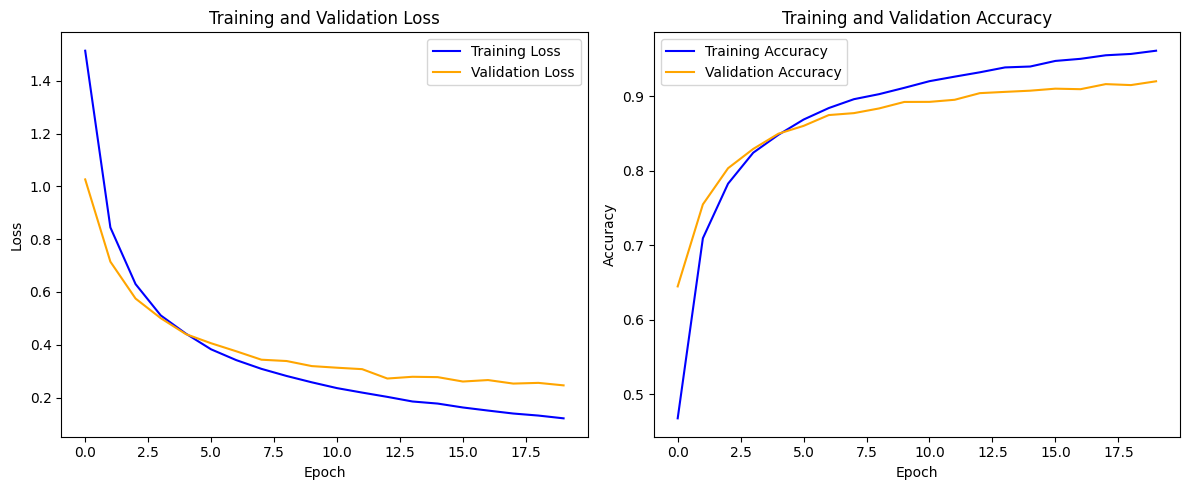

In [16]:
# Unpack the training and validation results for the best model
train_loss_history, val_loss_history, train_acc_history, val_acc_history = best_model_results[best_model_config]

# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy', color='blue')
plt.plot(val_acc_history, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Evaluate the best model

In [26]:
# Retrain the best model
best_model = initialize_model(best_model_name).to(device)
criterion = nn.CrossEntropyLoss()
num_epochs = 2
lr = best_model_config[1]
opt = best_model_config[2]
if opt == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=lr, weight_decay=0.01)
elif opt == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
else:
    optimizer = optim.RMSprop(best_model.parameters(), lr=lr)

for epoch in range(num_epochs):
    best_model, _, _ = train_model(best_model, train_loader, criterion, optimizer)

In [27]:
# best_model = initialize_model(best_model_name).to(device)
best_model.eval()

# Lists to store test predictions and true labels
all_preds = []
all_labels = []

# Run predictions on the test set
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for metrics calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate performance metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall metrics
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test F1 Score: {f1 * 100:.2f}%")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]))

Test Accuracy: 72.79%
Test Precision: 72.69%
Test Recall: 72.79%
Test F1 Score: 72.64%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.81      0.77      1000
  automobile       0.80      0.89      0.85      1000
        bird       0.63      0.59      0.61      1000
         cat       0.56      0.53      0.55      1000
        deer       0.66      0.64      0.65      1000
         dog       0.69      0.66      0.67      1000
        frog       0.75      0.81      0.78      1000
       horse       0.72      0.77      0.75      1000
        ship       0.87      0.81      0.84      1000
       truck       0.85      0.77      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

